# Physiological Signal Correlations

## Load Data

In [1]:
# misc directory is at the same level as scan directory, 
# so we need to change the current working directory to the root directory
# ONLY RUN THIS CELL ONCE

import os
os.chdir(os.path.dirname(os.getcwd()))

In [ ]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scan.io.load import DatasetLoad
from scipy.stats import rankdata

from main import (
    _concat_bootstrap_samples, 
    _generate_bootstrap_samples, 
    _physio_average
)

# load all phsyio siginals in dataset and concatenate
loader = DatasetLoad(
    'vanderbilt'
)
data, _ = loader.load(
    physio_high_pass=True, 
    func_high_pass=True,
    concat=False
)


loading scan: subj: 04 ses: 02
loading scan: subj: 09 ses: 02
loading scan: subj: 10 ses: 02
loading scan: subj: 14 ses: 01
loading scan: subj: 14 ses: 02
loading scan: subj: 15 ses: 02
loading scan: subj: 18 ses: 01
loading scan: subj: 18 ses: 02
loading scan: subj: 20 ses: 01
loading scan: subj: 20 ses: 02
loading scan: subj: 25 ses: 01
loading scan: subj: 25 ses: 02
loading scan: subj: 26 ses: 01
loading scan: subj: 27 ses: 02
loading scan: subj: 29 ses: 01
loading scan: subj: 29 ses: 02
loading scan: subj: 32 ses: 01
loading scan: subj: 36 ses: 01
loading scan: subj: 37 ses: 01
loading scan: subj: 37 ses: 02
loading scan: subj: 38 ses: 01
loading scan: subj: 38 ses: 02
loading scan: subj: 39 ses: 01
loading scan: subj: 39 ses: 02
loading scan: subj: 40 ses: 01
loading scan: subj: 40 ses: 02


In [33]:
eog = [
    data['physio']['eog1_amp'],
    data['physio']['eog2_amp']  
]
eog_mean = np.mean(np.hstack(eog), axis=1)
emg = [
    data['physio']['emg1_amp'],
    data['physio']['emg2_amp'],
    data['physio']['emg3_amp']
]
emg_mean = np.mean(np.hstack(emg), axis=1)

In [3]:
# get average of emg and eog channels
eog_mean, emg_mean = _physio_average(data, 'roi')
data['physio']['eog_mean'] = eog_mean
data['physio']['emg_mean'] = emg_mean

# get global signal
data['physio']['global_signal'] = [
    func.mean(axis=1)
    for func in data['func']
]

## Physio Cross-Correlations

### Weighted Correlation

In [4]:
class WeightedCorr:
    def __init__(self, xyw=None, x=None, y=None, w=None, df=None, wcol=None):
        ''' 
        Copied from:
        https://github.com/matthijsz/weightedcorr
        
        Weighted Correlation class. Either supply xyw, (x, y, w), or (df, wcol). Call the class to get the result, i.e.:
        WeightedCorr(xyw=mydata[[x, y, w]])(method='pearson')
        :param xyw: pd.DataFrame with shape(n, 3) containing x, y, and w columns (column names irrelevant)
        :param x: pd.Series (n, ) containing values for x
        :param y: pd.Series (n, ) containing values for y
        :param w: pd.Series (n, ) containing weights
        :param df: pd.Dataframe (n, m+1) containing m phenotypes and a weight column
        :param wcol: str column of the weight column in the dataframe passed to the df argument.
        '''
        if (df is None) and (wcol is None):
            if np.all([i is None for i in [xyw, x, y, w]]):
                raise ValueError('No data supplied')
            if not ((isinstance(xyw, pd.DataFrame)) != (np.all([isinstance(i, pd.Series) for i in [x, y, w]]))):
                raise TypeError('xyw should be a pd.DataFrame, or x, y, w should be pd.Series')
            xyw = pd.concat([x, y, w], axis=1).dropna() if xyw is None else xyw.dropna()
            self.x, self.y, self.w = (pd.to_numeric(xyw[i], errors='coerce').values for i in xyw.columns)
            self.df = None
        elif (wcol is not None) and (df is not None):
            if (not isinstance(df, pd.DataFrame)) or (not isinstance(wcol, str)):
                raise ValueError('df should be a pd.DataFrame and wcol should be a string')
            if wcol not in df.columns:
                raise KeyError('wcol not found in column names of df')
            self.df = df.loc[:, [x for x in df.columns if x != wcol]]
            self.w = pd.to_numeric(df.loc[:, wcol], errors='coerce')
        else:
            raise ValueError('Incorrect arguments specified, please specify xyw, or (x, y, w) or (df, wcol)')

    def _wcov(self, x, y, ms):
        return np.sum(self.w * (x - ms[0]) * (y - ms[1]))

    def _pearson(self, x=None, y=None):
        x, y = (self.x, self.y) if ((x is None) and (y is None)) else (x, y)
        mx, my = (np.sum(i * self.w) / np.sum(self.w) for i in [x, y])
        return self._wcov(x, y, [mx, my]) / np.sqrt(self._wcov(x, x, [mx, mx]) * self._wcov(y, y, [my, my]))

    def _wrank(self, x):
        (unique, arr_inv, counts) = np.unique(rankdata(x), return_counts=True, return_inverse=True)
        a = np.bincount(arr_inv, self.w)
        return (np.cumsum(a) - a)[arr_inv]+((counts + 1)/2 * (a/counts))[arr_inv]

    def _spearman(self, x=None, y=None):
        x, y = (self.x, self.y) if ((x is None) and (y is None)) else (x, y)
        return self._pearson(self._wrank(x), self._wrank(y))

    def __call__(self, method='pearson'):
        '''
        :param method: Correlation method to be used: 'pearson' for pearson r, 'spearman' for spearman rank-order correlation.
        :return: if xyw, or (x, y, w) were passed to __init__ returns the correlation value (float).
                 if (df, wcol) were passed to __init__ returns a pd.DataFrame (m, m), the correlation matrix.
        '''
        if method not in ['pearson', 'spearman']:
            raise ValueError('method should be one of [\'pearson\', \'spearman\']')
        cor = {'pearson': self._pearson, 'spearman': self._spearman}[method]
        if self.df is None:
            return cor()
        else:
            out = pd.DataFrame(np.nan, index=self.df.columns, columns=self.df.columns)
            for i, x in enumerate(self.df.columns):
                for j, y in enumerate(self.df.columns):
                    if i >= j:
                        out.loc[x, y] = cor(x=pd.to_numeric(self.df[x], errors='coerce'), y=pd.to_numeric(self.df[y], errors='coerce'))
                        out.loc[y, x] = out.loc[x, y]
            return out


def cross_corr(
    x: pd.Series | np.ndarray, 
    y: pd.Series | np.ndarray, 
    w: pd.Series | None = None, 
    lags: int = 20
) -> List[float]:
    """
    Calculate the cross-correlation between two signals. The weights are 
    not shifted with the lags.

    Parameters
    ----------
    x : pd.Series | np.ndarray
        The first signal.
    y : pd.Series | np.ndarray
        The second signal. This is the signal that is shifted.
    w : pd.Series | None, optional
        The weights for the signals. If None, all weights are set to 1.
    lags : int, optional
        The number of lags to calculate the cross-correlation for.

    Returns
    -------
    cc : List[float]
        The cross-correlation between the two signals.

    """
    if not isinstance(x, pd.Series):
        x = pd.Series(np.squeeze(x))
    if not isinstance(y, pd.Series):
        y = pd.Series(np.squeeze(y))

    if w is None:
        w = pd.Series(np.ones(len(x)))
    else:
        if not isinstance(w, pd.Series):
            w = pd.Series(np.squeeze(w))

    cc = []
    for lag in range(-lags, lags+1):
        y_lag = y.shift(lag)
        corr = WeightedCorr(
            x=x,
            y=y_lag,
            w=w
        )('pearson')
        cc.append(corr)
    return cc

### Cross-Correlation Plot

Bootstrap sample 1 of 500
Bootstrap sample 101 of 500
Bootstrap sample 201 of 500
Bootstrap sample 301 of 500
Bootstrap sample 401 of 500


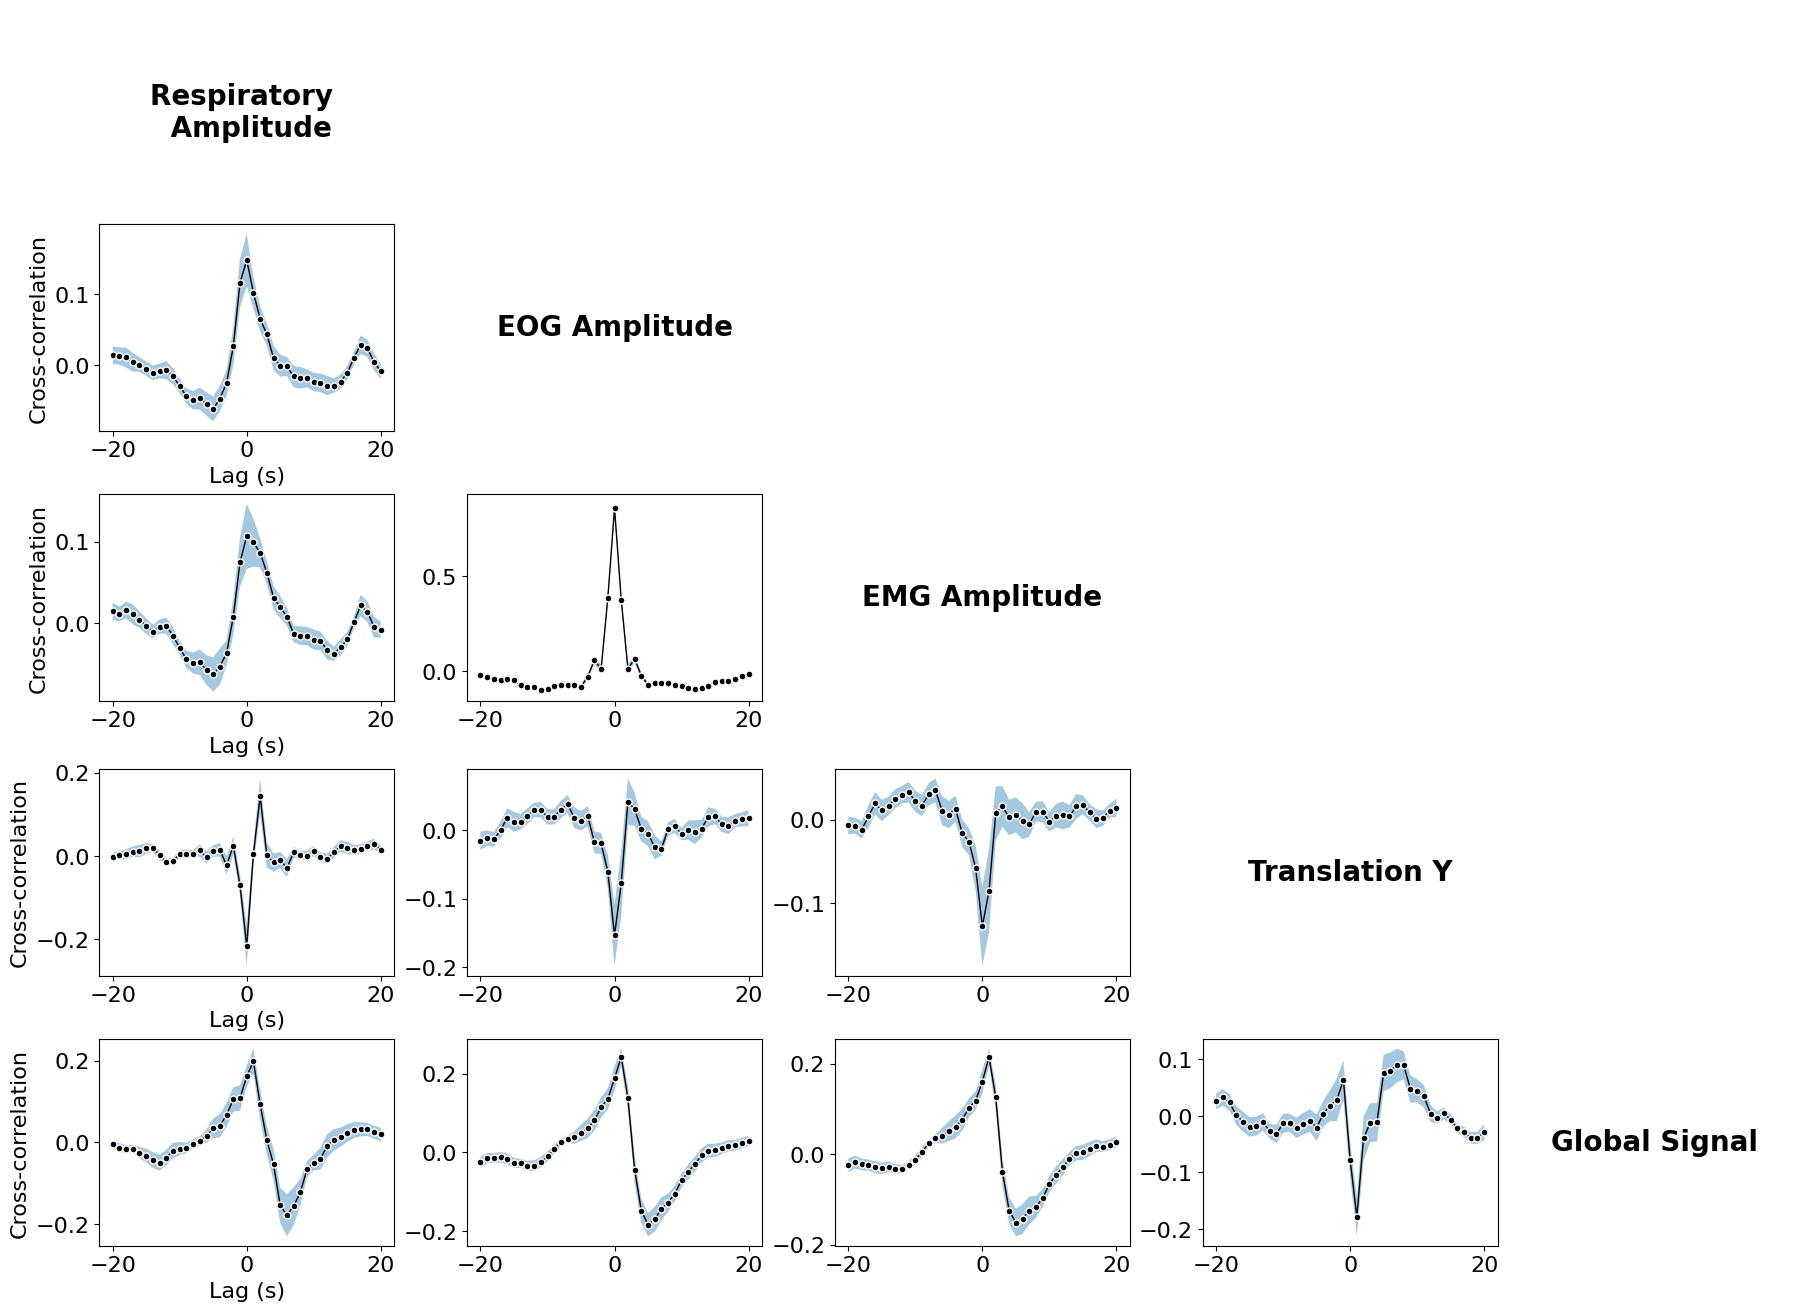

In [6]:
%matplotlib inline
# define physio labels in plot
physio_labels = [
    'resp_amp',
    'eog_mean',
    'emg_mean',
    'trans_y',
    'global_signal'
]

label_map = {
    'eog_mean': 'EOG Amplitude',
    'emg_mean': 'EMG Amplitude',
    'resp_amp': 'Respiratory \n Amplitude',
    'trans_y': 'Translation Y',
    'global_signal': 'Global Signal'
}

# construct bootstrap cross-correlation samples
n_samples = 500
n_lags = 20
# get subject session list
subject_session_list = list(loader.iter)
# generate 500 bootstrap samples
bootstrap_samples = _generate_bootstrap_samples(
    subject_session_list, 
    n_bootstrap=n_samples
)
# loop through bootstrap samples and calculate cross-correlation between 
# all physio labels
# initialize empty dict to store cross-correlation results
cc_results = {
    px: {py: [] for py in physio_labels} 
    for px in physio_labels
}
for i, sample in enumerate(bootstrap_samples):
    if i % 100 == 0:
        print(f'Bootstrap sample {i+1} of {len(bootstrap_samples)}')
    data_out = _concat_bootstrap_samples(
        sample, subject_session_list, data['physio']
    )
    for i in range(len(physio_labels)):
        for j in range(len(physio_labels)):
            if i > j:
                # if respiratory amplitude, there was periods of signal
                # loss, so we need to use sample weights to account for this
                if physio_labels[i] == 'resp_amp':
                    weights = data_out['weight']
                else:
                    weights = None
                cc = cross_corr(
                    x=data_out[physio_labels[i]],
                    y=data_out[physio_labels[j]],
                    w=weights,
                    lags=n_lags
                )
                cc_results[physio_labels[i]][physio_labels[j]].append(cc)

# plot physio labels
fig, axs = plt.subplots(
    nrows=5, ncols=5, layout='constrained',
    figsize=(18, 13)
)
for i in range(len(physio_labels)):
    for j in range(len(physio_labels)):
        if i > j: # cross-correlation
            # get mean and std of cross-correlation
            cc_mean = np.mean(
                cc_results[physio_labels[i]][physio_labels[j]],
                axis=0
            )
            cc_std = np.std(
                cc_results[physio_labels[i]][physio_labels[j]],
                axis=0
            )
            axs[i, j].plot(
                np.arange(-n_lags, n_lags+1),
                cc_mean,
                color='black',
                linewidth=1,
                marker='o',
                markersize=5,
                markeredgecolor='white',
                markerfacecolor='black',
                markeredgewidth=1,
            )
            axs[i, j].fill_between(
                np.arange(-n_lags, n_lags+1),
                cc_mean - cc_std,
                cc_mean + cc_std, 
                alpha=0.4
            )
            axs[i,j].tick_params(axis='both', which='major', labelsize=16)
            if j == 0:
                axs[i, j].set_xlabel('Lag (s)', fontsize=16)
                axs[i, j].set_ylabel('Cross-correlation', fontsize=16)

        if i == j: # physio title
            axs[i, j].text(
                0.5, 0.5, f'{label_map[physio_labels[i]]}',
                ha='center', va='center',
                fontsize=20,
                fontweight='bold'
            )
            axs[i, j].set_axis_off()
        if i < j: # off
            axs[i, j].set_axis_off()

plt.show()

In [29]:
cc_mean = np.mean(cc_results['emg_mean']['eog_mean'],
                axis=0)
cc_mean[20]


0.8577576951763108